<header><font size="+3"> <center> <b> Solving the Ising model using GANs </b></center></font></header>

## Preamble

In [1]:
import pickle as pk
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["text.usetex"] = True

In [3]:
N = 64

In [4]:
Tc = 2.269185

# Import training images

In [5]:
T = 1

In [6]:
train_data = np.fromfile("mcdata/new_64_" + str(T) + ".dat", dtype=np.int64)

In [7]:
train_data.shape = -1, 1, N, N
train_data_tensor = torch.tensor(train_data, dtype=torch.double)

train_data.shape

(2000, 1, 64, 64)

In [8]:
batch_size = 64

In [9]:
dataloader = torch.utils.data.DataLoader(train_data_tensor,
                                         batch_size=batch_size, shuffle=False)

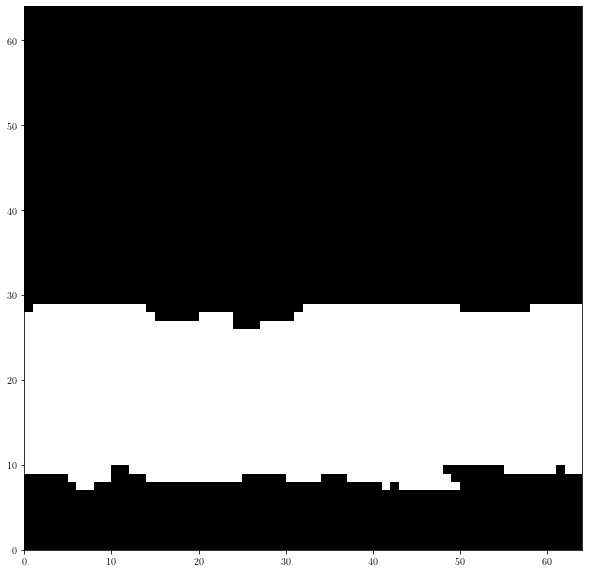

In [10]:
plt.pcolormesh(train_data[-1, :, :][0],
              cmap="binary");

# True magnetization distribution

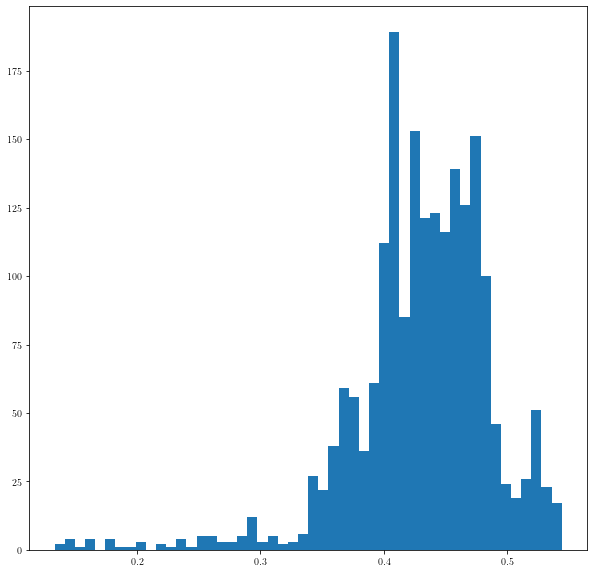

In [11]:
plt.hist(np.abs(train_data.mean((-1, -2))), bins=50);

# Define the net architecture

## Generator

The generator is a deep transpose-convolutional network:

In [12]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        
        super(Generator, self).__init__()
        
        self.ngpu = ngpu
        self.main = nn.Sequential(            
            # Layer 1
            nn.ConvTranspose2d(inp_dim, Ngen_ker * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(Ngen_ker * 8),
            nn.ReLU(True),

            # Layer 2
            nn.ConvTranspose2d(Ngen_ker * 8, Ngen_ker * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Ngen_ker * 4),
            nn.ReLU(True),
            
            # Layer 3
            nn.ConvTranspose2d( Ngen_ker * 4, Ngen_ker * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Ngen_ker * 2),
            nn.ReLU(True),
            
            # Layer 4
            nn.ConvTranspose2d( Ngen_ker * 2, Ngen_ker, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Ngen_ker),
            nn.ReLU(True),
            
            # output layer
            nn.ConvTranspose2d( Ngen_ker, n_channel, 4, 2, 1, bias=False),
            nn.Tanh()           
        )

    def forward(self, input):
        return self.main(input)

## Discriminator

Using spectral norm, code taken from: https://github.com/christiancosgrove/pytorch-spectral-normalization-gan/blob/master/spectral_normalization.py

In [13]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

The discriminator

In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        
        super(Discriminator, self).__init__()
        
        self.ngpu = ngpu
        
        self.main = nn.Sequential(
            # Layer 1
            nn.Conv2d(n_channel, Ndis_ker, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 2
            nn.Conv2d(Ndis_ker, Ndis_ker * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Ndis_ker * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 3
            nn.Conv2d(Ndis_ker * 2, Ndis_ker * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Ndis_ker * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 4
            nn.Conv2d(Ndis_ker * 4, Ndis_ker * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(Ndis_ker * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Layer 5
            nn.Conv2d(Ndis_ker * 8, 1, 4, 1, 0, bias=False)
        )

    def forward(self, input):
        return self.main(input)

# pytorch config

In [15]:
# number of channels
n_channel = 1

# input dimension
inp_dim = 100

# kernel sizes
Ngen_ker = 64
Ndis_ker = 64

# number of epochs and regularization constants
num_epochs = 5
gamma = 0.0001
beta1 = 0.5
ngpu = torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Init

From here:
https://discuss.pytorch.org/t/weight-initilzation/157/5

In [16]:
def weights_init(m):    
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [17]:
# Generator
generator = Generator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    generator = nn.DataParallel(generator, list(range(ngpu)))
generator.apply(weights_init);

In [18]:
# Discriminator
discriminator = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    discriminator = nn.DataParallel(discriminator, list(range(ngpu)))

In [19]:
# Pytorch prefers 0/1 labels
real_label = 1
fake_label = 0

In [20]:
mag_loss = nn.MSELoss()

In [21]:
# Optimizer
optimizerD = optim.Adam(discriminator.parameters(), lr=gamma, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=gamma, betas=(beta1, 0.999))

# Train 

In [30]:
loss_G = []
loss_D = []
itr = 0

outputF = 75

for epoch in range(num_epochs):
    
    for i, dat in enumerate(dataloader):

        ### Discriminator update
        discriminator.zero_grad()        
        
        # Real data
        data = dat.to(device)
        bSize = data.size(0)
        labels = torch.full((bSize,), real_label, device=device)
        
        # There is a symmetry between identical "white" and "black" states
        # flip it
        sign = torch.sign(torch.sum(data, (-1,-2, -3)))
        sign = sign.cpu().numpy().reshape((sign.shape[0], 1, 1, 1))              
        data = torch.from_numpy(sign * data.cpu().numpy()).to(device)
              
        # Forward pass - real data
        data_D = discriminator(data.float()).view(-1)        
        # Hinge loss
        D_err_data = nn.ReLU()(1.0 - data_D).mean()
        
        # Generated data
        noise = torch.randn(bSize, inp_dim, 1, 1, device=device)
        generated = generator(noise)        
        labels.fill_(fake_label)
        
        # Forward pass - generated data
        generated_D = discriminator(generated.detach()).view(-1)         
        # Hinge loss
        D_err_gen = nn.ReLU()(1.0 + generated_D).mean()
        
        # The discriminator's overall loss:
        D_err = D_err_data + D_err_gen
        
        # Discriminator update
        D_err.backward()
        optimizerD.step()
        
        # magnetization
        real_mag = torch.mean(data, (-1, -2, -3))
        fake_mag = torch.mean(generated, (-1,-2,-3))
        
        
        ### Generator update
        generator.zero_grad()
        labels.fill_(real_label)
        
        # use the updated discriminator
        feedback = discriminator(generated).view(-1)
        
        # Generator's loss
        G_err = -1.0 * torch.mean(feedback) +\
            mag_loss(real_mag.float().to(device), fake_mag.float().to(device))
              
        # Generator update
        G_err.backward()
        optimizerG.step()
               
        # print:
        if i % outputF == 0:
            print(f"""Epoch: {epoch} / {num_epochs} Batch: {i} / {len(dataloader)}"""
                  f""" Generator loss: {round(G_err.item(), 2)} Discriminator loss: {round(D_err.item(), 2)}""")
            
        loss_G.append(G_err.item())
        loss_D.append(D_err.item())
        
        itr += 1

Epoch: 0 / 5 Batch: 0 / 32 Generator loss: 2.31 Discriminator loss: 0.1
Epoch: 1 / 5 Batch: 0 / 32 Generator loss: 2.46 Discriminator loss: 0.04
Epoch: 2 / 5 Batch: 0 / 32 Generator loss: 1.69 Discriminator loss: 3.09
Epoch: 3 / 5 Batch: 0 / 32 Generator loss: 0.73 Discriminator loss: 4.83
Epoch: 4 / 5 Batch: 0 / 32 Generator loss: 2.24 Discriminator loss: 0.48


In [337]:
T

5

In [338]:
pk.dump(generator, open("models/generator" + str(T) + ".pkl", 'wb'))

# Data Evaluation

In [313]:
generator = pk.load(open("models/generator" + str(T) + ".pkl", 'rb'))

In [32]:
n_gen = 1000
gen_data = generator.cpu()(torch.randn(n_gen, inp_dim, 1, 1))

In [33]:
gen_data = gen_data.detach().numpy()
gen_data[gen_data >= 0] = 1
gen_data[gen_data < 0] = -1

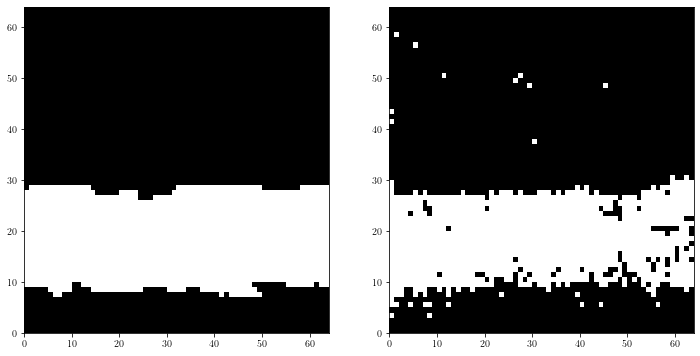

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.pcolormesh(train_data[1999, :, :, :][0], cmap='binary');
ax2.pcolormesh(gen_data[999, :, :, :][0], cmap='binary');

In [37]:
gen_mag = abs(np.mean(gen_data, (-1,-2,-3)))
data_mag = abs(np.mean(train_data, (-1,-2,-3)))

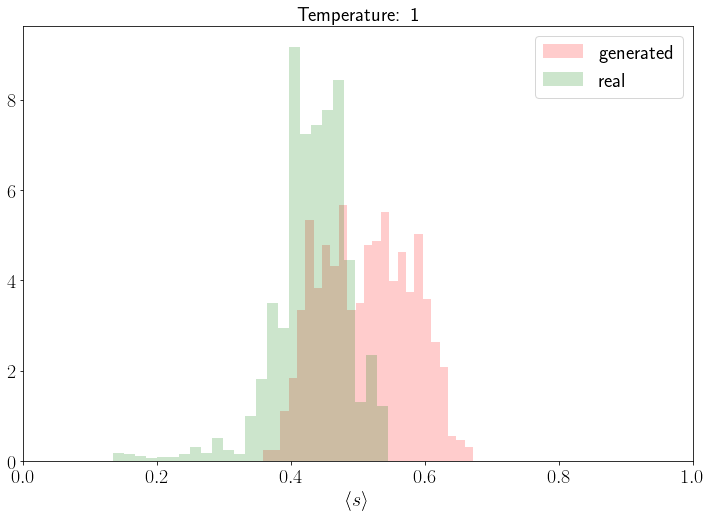

In [42]:
plt.figure(figsize=(12,8))
plt.hist(gen_mag,  label='generated', color = 'r', alpha = 0.2, bins = 25, density=True)
plt.hist(data_mag, label ='real', color = 'g', alpha = 0.2, bins = 25, density=True)
plt.xlim(0, 1)

plt.legend(loc='upper right',fontsize=20)

plt.title("Temperature: " + str(T), fontsize=20)
plt.xlabel('$\langle s \\rangle$', fontsize=20)
plt.xticks(fontsize=20);
plt.yticks(fontsize=20);